For this tutorial we use a dataset from chronic recordings collected for Steinmetz et al. 2021. This is a subset of the data available [here](https://rdr.ucl.ac.uk/articles/dataset/Chronic_recordings_from_Neuropixels_2_0_probes_in_mice/24411841).

The dataset was collected by _Anna Lebedeva_ in the Carandini/Harris lab at UCL from animal _AL032_, and prepared by _Jennifer Colonell_ (HHMI, Janelia). 

**Only data from shank0 and recording day 2019-11-21 are provided.**

For experimental details about the recording (specifically: the experiment in Figure 4 of the paper, Supplementary methods 1.2 Chronic recordings in Carandini/Harris Lab at UCL)

In [2]:
from pathlib import Path
import numpy as np 
import pylab as plt
# for interactivity
%matplotlib ipympl 

# outfolder = Path('./data/AL032_out/') # this should be the kilosort output folder
outfolder = Path(r'Y:\SGL_DATA_drive\wmm001_250705_rec_d12\catgt_wmm001_250705_rec_d12_g0\wmm001_250705_rec_d12_g0_imec0\imec0_ks4')

from helpers import load_phy_folder  # load the function from the previous tutorial
res = load_phy_folder(outfolder) # this is converted to a function in the helpers
sampling_rate = 30000 # this can be read from the params.py file or from the .meta

from scipy.io import loadmat # load matlab files in python
mat = loadmat(outfolder.parent/'AL032_stimulus/AL032_stimulus_times.mat',squeeze_me=True)

stimtimes = mat['sorted_response'][np.where(mat['day_label'] == '2019-11-21')].squeeze()
stimtimes = np.stack(stimtimes) # ntrial x nstim x feature


OSError: Reader needs file name or open file-like object

It is often useful to get an overview of task or stimulus events in the context of the drift raster, these can be easily overlayed.

Based on the previous plot, there is a function in the helpers to a ``plot_drift_raster``

<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
C:\Users\NeuropixelsComp\AppData\Local\Temp\ipykernel_30004\3145605781.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Depth from probe tip ($\mu$m)',fontsize = 14)
C:\Users\NeuropixelsComp\AppData\Local\Temp\ipykernel_30004\3145605781.py:9: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('Depth from probe tip ($\mu$m)',fontsize = 14)


NameError: name 'stimtimes' is not defined

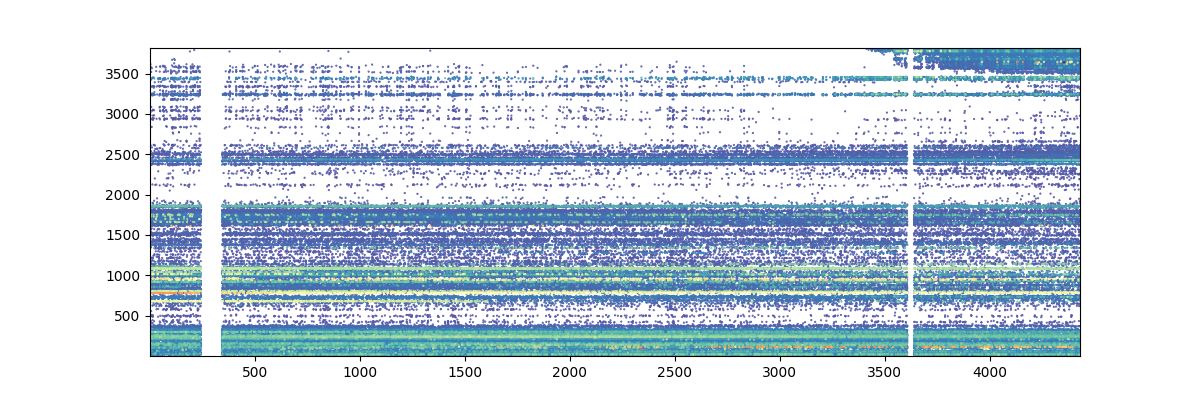

In [3]:
from helpers import plot_drift_raster
# plot the stim times alongside
plot_drift_raster(spiketimes = res['spike_times']/sampling_rate,
                  spikepositions = res['spike_positions'],
                  spikeamplitudes = res['spike_amplitudes'])
                  
plt.vlines(stimtimes[:,:,1],*plt.ylim(),lw = 0.3,color = 'k')

plt.ylabel('Depth from probe tip ($\mu$m)',fontsize = 14)
plt.xlabel('Experiment time (s)',fontsize = 14);
plt.xlim([0,600]);

It is hard to see the effect of the stimulus, lets plot a ``PSTH`` **peri-stimulus time histogram** of population activity. This, together with **trial rasters** should tell us if the synchronization between the streams is ok.

In [ ]:
# triggered psth
interval = [-0.5,1.5]

ev = stimtimes[:,:,1].flatten()
ts = res['spike_times']/sampling_rate

triggered_population = [ts[(ts>interval[0]+e) & (ts<interval[1]+e)] - e for e in ev]
binsize = 0.01
bins = np.arange(*interval,binsize)
# create a histogram of the trials separately so we can get a mean and std easily
pop_psths = np.stack([np.histogram(t,bins = bins)[0] for t in triggered_population]).astype('float32')
pop_psths /= binsize
t = bins[1:] - np.diff(bins[:2])/2
plt.figure()
psth = np.mean(pop_psths,axis = 0)
psth_sem =  np.std(pop_psths,axis = 0)/np.sqrt(len(pop_psths))

plt.fill_between(t,psth+psth_sem,psth-psth_sem,color = 'gray')
plt.plot(t,psth,'k')
plt.ylim([0,np.max(plt.ylim())])
plt.xlim(*interval)
plt.vlines([0,1],*plt.ylim(),color = 'r',linestyle = '--',lw =0.5)
plt.ylabel('Multi-unit spikes/second',fontsize = 16)
plt.xlabel('Time from stim onset (s)',fontsize = 16);

We can see an rise in activity when the stimulus comes on as expected in _primary visual cortex_. Lets now look at the response of individual cells to the stimuli.

In [ ]:
# first lets create a list of spikes for each clusters
unit_spikes = []
for iclu in res['metrics'].cluster_id.values:
    unit_spikes.append(np.take(res['spike_times'],np.where(res['spike_clusters']==iclu)[0])/sampling_rate)
print(f'Gathered spike times from {len(unit_spikes)} units.')

# extract a raster for each unit for each stimuli
ntrials,nstims ,_ = stimtimes.shape 
triggered_activity = []
interval = [-0.5,1.5]
for ts in unit_spikes: # iterate over units
    triggered_activity.append([])
    for istim in range(nstims): # iterate over stimuli
        ev = stimtimes[:,istim,1]
        triggered_activity[-1].extend([ts[(ts>interval[0]+e) & (ts<interval[1]+e)] - e for e in ev])

print(f'Gathered the activity from {nstims} stims and {ntrials} trials.')


Lets now use ``ipywidgets`` to cycle through all cells.

In [ ]:

# plot an interactive raster to go over the activity of the cells
fig = plt.figure()
from ipywidgets import IntSlider,interact
@interact(icell = IntSlider(val =0, min=0,max=len(unit_spikes)-1))
def raster_slider(icell):
    triggered = triggered_activity[icell]
    trial_index = np.hstack([i*np.ones_like(s) for i,s in enumerate(triggered)])
    trial_spikes = np.hstack(triggered)
    fig.clf()
    scatt = plt.scatter(trial_spikes,trial_index,5,'k',marker = '|');
    plt.title(f"Unit {int(res['metrics'].iloc[icell]['cluster_id'])}")
    plt.xlim(interval)
    plt.ylim([0,len(triggered_activity[0])]);
    plt.vlines([0,1],*plt.ylim(),color = 'r',linestyle = '-',lw = 0.5);


**Exercise**

Plot a PSTH aligned with the rasters and cicle through all cells using the slider.

---


There are 112 stimuli in this dataset. Some cells might prefer one stimuli over another. We will reproduce the analysis in figure 4c of the [Steinmetz et al. 2021](https://www.science.org/doi/10.1126/science.abf4588) paper.

In [ ]:
# plot "fingerprints" - these are the average response to each stimuli subtracted by the average response during the stim period

fingerprints = []
interval = [0,1]
for ts in unit_spikes: # iterate over units
    fingerprints.append([])
    for istim in range(stimtimes.shape[1]): # iterate over stimuli
        ev = stimtimes[:,istim,1]
        fingerprints[-1].append(np.mean([len(ts[(ts>interval[0]+e) & (ts<interval[1]+e)]) for e in ev]))
fingerprints = np.stack(fingerprints)
fingerprints = (fingerprints.T - fingerprints.mean(axis = 1)).T
plt.figure(figsize = [11,5])

plt.imshow(fingerprints,cmap = 'RdBu_r',clim = [-5,5],interpolation='none',aspect = 'auto')
plt.colorbar(label='Firing rate change',shrink = 0.5)
plt.ylabel('Unit index',fontsize = 16)
plt.xlabel('Visual stimulus #',fontsize = 16);

We are plotting over 200 cells and it becomes difficult to isolate if there are groups of cells that have similar responses. We can use **similarity** clustering to sort the cells by their responses.

In [ ]:
# use hierarchical clustering to group similar "fingerprints"
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, dendrogram,fcluster


dist_matrix = pdist(fingerprints, metric='euclidean')
linkage_matrix = linkage(dist_matrix, method='ward')
idx = np.argsort(fcluster(linkage_matrix,fingerprints.shape[1],criterion='maxclust'))

plt.figure(figsize = [11,5])
plt.imshow(fingerprints[idx],cmap = 'RdBu_r',clim = [-5,5],interpolation='none',aspect = 'auto')
plt.colorbar(label='Firing rate change',shrink = 0.5)
plt.ylabel('Units (sorted by similarity)',fontsize = 16)
plt.xlabel('Visual stimulus #',fontsize = 16);

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
norm_spikecounts = sc.fit_transform(fingerprints)

from sklearn.decomposition import PCA
pca = PCA(n_components=4)

reduced = pca.fit_transform(norm_spikecounts[:,:])